In [1]:
import numpy as np
import os
import re
import scipy.io as scio

import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

产生数据

In [2]:
raw_num = 240
col_num = 2000

class Data(object):
    
    def __init__(self):
        self.data = self.get_data()
        self.label = self.get_label()
        
    def file_list(self):
        return os.listdir('data/')
    
    def get_data(self):
        file_list = self.file_list()
        for i in range(len(file_list)):
            file = scio.loadmat('data/{}'.format(file_list[i]))
            for k in file.keys():
                file_matched = re.match('X\d{3}_DE_time', k)
                if file_matched:
                    key = file_matched.group()
            if i == 0:
                data = np.array(file[key][0:480000].reshape(raw_num,col_num))
            else:
                data = np.vstack((data, file[key][0:480000].reshape((raw_num,col_num))))
        return data
    
    def get_label(self):
        file_list = self.file_list()
        title = np.array([i.replace('.mat', '') for i in file_list])
        label = title[:, np.newaxis]
        label_copy = np.copy(label)
        for _ in range(raw_num-1):
            label = np.hstack((label, label_copy))
        return label.flatten()

In [3]:
Data = Data()
data = Data.data
label = Data.label
lb = LabelBinarizer()
y = lb.fit_transform(label)

# Wiener filtering
data_wiener = scipy.signal.wiener(data, mysize=3, noise=None)

# downsampling
index = np.arange(0,2000, 8)
data_samp = data_wiener[:, index]
print(data_samp.shape)

(2400, 250)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data_samp, y, test_size=0.3)

In [5]:
def built_model():
    
    input_seq = Input(shape=(250,))
    X = Reshape((1,250))(input_seq)
    
    # encoder1
    ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(X)
    ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2,
                      padding='valid', activation='tanh',
                      data_format='channels_first')(ec1_layer1)
    ec1_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec1_layer2)
    
    # encoder2
    ec2_layer1 = Conv1D(filters=50, kernel_size=6, strides=1,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(X)
    ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=1,
                      padding='valid', activation='tanh',
                      data_format='channels_first')(ec2_layer1)
    ec2_layer3 = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec2_layer2)
    ec2_layer4 = Conv1D(filters=30, kernel_size=6, strides=1,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(ec2_layer3)
    ec2_layer5 = Conv1D(filters=30, kernel_size=6, strides=2,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(ec2_layer4)
    ec2_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec2_layer5)
    
    encoder = multiply([ec1_outputs, ec2_outputs])
    
    dc_layer1 = LSTM(60, return_sequences=True)(encoder)
    dc_layer2 = LSTM(60)(dc_layer1)
    dc_layer3 = Dropout(0.5)(dc_layer2)
    dc_layer4 = Dense(10, activation='softmax')(dc_layer3)
    
    model = Model(input_seq, dc_layer4)
    
    return model

In [6]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.imshow(cm , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=40)
    plt.yticks(tick_mark, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = '%.2f'%cm
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [7]:
import time
begain_time = time.time()

In [8]:
model = built_model()
opt = Adam(lr=0.0006)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 250)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 50, 245)      350         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)    

In [9]:
history = model.fit(x=X_train, y=y_train, batch_size = 100, epochs=400, 
                    verbose=2, validation_data=(X_test, y_test),
                    shuffle=True, initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Train on 1680 samples, validate on 720 samples
Epoch 1/400
 - 6s - loss: 0.0898 - acc: 0.1542 - val_loss: 0.0890 - val_acc: 0.0861
Epoch 2/400
 - 2s - loss: 0.0857 - acc: 0.1202 - val_loss: 0.0839 - val_acc: 0.2014
Epoch 3/400
 - 2s - loss: 0.0803 - acc: 0.2226 - val_loss: 0.0806 - val_acc: 0.1903
Epoch 4/400
 - 2s - loss: 0.0779 - acc: 0.2470 - val_loss: 0.0767 - val_acc: 0.2806
Epoch 5/400
 - 2s - loss: 0.0735 - acc: 0.3107 - val_loss: 0.0749 - val_acc: 0.2667
Epoch 6/400
 - 2s - loss: 0.0716 - acc: 0.3226 - val_loss: 0.0768 - val_acc: 0.2750
Epoch 7/400
 - 2s - loss: 0.0712 - acc: 0.3643 - val_loss: 0.0706 - val_acc: 0.3431
Epoch 8/400
 - 2s - loss: 0.0672 - acc: 0.3929 - val_loss: 0.0683 - val_acc: 0.3569
Epoch 9/400
 - 2s - loss: 0.0654 - acc: 0.3976 - val_loss: 0.0668 - val_acc: 0.4736
Epoch 10/400
 - 2s - loss: 0.0639 - acc: 0.4185 - val_loss: 0.0680 - val_acc: 0.3764
Epoch 11/400
 - 2s - loss: 0.0671 - acc: 0.3976 - val_loss: 0.06

Epoch 94/400
 - 2s - loss: 0.0104 - acc: 0.9339 - val_loss: 0.0175 - val_acc: 0.8792
Epoch 95/400
 - 2s - loss: 0.0104 - acc: 0.9387 - val_loss: 0.0155 - val_acc: 0.8917
Epoch 96/400
 - 2s - loss: 0.0097 - acc: 0.9387 - val_loss: 0.0127 - val_acc: 0.9208
Epoch 97/400
 - 2s - loss: 0.0084 - acc: 0.9554 - val_loss: 0.0117 - val_acc: 0.9222
Epoch 98/400
 - 2s - loss: 0.0074 - acc: 0.9565 - val_loss: 0.0118 - val_acc: 0.9236
Epoch 99/400
 - 2s - loss: 0.0066 - acc: 0.9655 - val_loss: 0.0130 - val_acc: 0.9181
Epoch 100/400
 - 2s - loss: 0.0054 - acc: 0.9732 - val_loss: 0.0233 - val_acc: 0.8653
Epoch 101/400
 - 2s - loss: 0.0173 - acc: 0.9083 - val_loss: 0.0190 - val_acc: 0.8736
Epoch 102/400
 - 2s - loss: 0.0096 - acc: 0.9405 - val_loss: 0.0133 - val_acc: 0.9139
Epoch 103/400
 - 2s - loss: 0.0074 - acc: 0.9554 - val_loss: 0.0180 - val_acc: 0.8903
Epoch 104/400
 - 2s - loss: 0.0123 - acc: 0.9345 - val_loss: 0.0171 - val_acc: 0.9028
Epoch 105/400
 - 2s - loss: 0.0122 - acc: 0.9327 - val_loss:

Epoch 188/400
 - 2s - loss: 3.1542e-04 - acc: 0.9988 - val_loss: 0.0043 - val_acc: 0.9764
Epoch 189/400
 - 2s - loss: 3.1696e-04 - acc: 0.9988 - val_loss: 0.0042 - val_acc: 0.9764
Epoch 190/400
 - 2s - loss: 3.3037e-04 - acc: 0.9988 - val_loss: 0.0045 - val_acc: 0.9736
Epoch 191/400
 - 2s - loss: 2.9387e-04 - acc: 0.9988 - val_loss: 0.0040 - val_acc: 0.9792
Epoch 192/400
 - 2s - loss: 3.6765e-04 - acc: 0.9988 - val_loss: 0.0044 - val_acc: 0.9750
Epoch 193/400
 - 2s - loss: 3.3042e-04 - acc: 0.9988 - val_loss: 0.0044 - val_acc: 0.9764
Epoch 194/400
 - 2s - loss: 3.1275e-04 - acc: 0.9988 - val_loss: 0.0043 - val_acc: 0.9764
Epoch 195/400
 - 2s - loss: 3.0052e-04 - acc: 0.9988 - val_loss: 0.0040 - val_acc: 0.9778
Epoch 196/400
 - 2s - loss: 2.9784e-04 - acc: 0.9988 - val_loss: 0.0044 - val_acc: 0.9764
Epoch 197/400
 - 2s - loss: 3.5731e-04 - acc: 0.9988 - val_loss: 0.0052 - val_acc: 0.9722
Epoch 198/400
 - 2s - loss: 3.1829e-04 - acc: 0.9988 - val_loss: 0.0057 - val_acc: 0.9667
Epoch 199/

Epoch 280/400
 - 2s - loss: 3.0156e-04 - acc: 0.9982 - val_loss: 0.0037 - val_acc: 0.9764
Epoch 281/400
 - 2s - loss: 2.8638e-04 - acc: 0.9988 - val_loss: 0.0029 - val_acc: 0.9833
Epoch 282/400
 - 2s - loss: 1.6846e-04 - acc: 0.9994 - val_loss: 0.0030 - val_acc: 0.9833
Epoch 283/400
 - 2s - loss: 1.9868e-04 - acc: 0.9988 - val_loss: 0.0030 - val_acc: 0.9833
Epoch 284/400
 - 2s - loss: 1.8125e-04 - acc: 0.9994 - val_loss: 0.0030 - val_acc: 0.9833
Epoch 285/400
 - 2s - loss: 1.3887e-04 - acc: 0.9994 - val_loss: 0.0030 - val_acc: 0.9819
Epoch 286/400
 - 2s - loss: 1.6779e-04 - acc: 0.9994 - val_loss: 0.0029 - val_acc: 0.9847
Epoch 287/400
 - 2s - loss: 2.1033e-04 - acc: 0.9988 - val_loss: 0.0029 - val_acc: 0.9847
Epoch 288/400
 - 2s - loss: 1.7610e-04 - acc: 0.9994 - val_loss: 0.0029 - val_acc: 0.9847
Epoch 289/400
 - 2s - loss: 1.6463e-04 - acc: 0.9994 - val_loss: 0.0029 - val_acc: 0.9847
Epoch 290/400
 - 2s - loss: 1.5526e-04 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 0.9861
Epoch 291/

 - 2s - loss: 1.0498e-04 - acc: 0.9994 - val_loss: 0.0033 - val_acc: 0.9833
Epoch 372/400
 - 2s - loss: 1.6931e-04 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 0.9847
Epoch 373/400
 - 2s - loss: 1.2475e-04 - acc: 0.9994 - val_loss: 0.0027 - val_acc: 0.9847
Epoch 374/400
 - 2s - loss: 1.1898e-04 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 0.9847
Epoch 375/400
 - 2s - loss: 1.0327e-04 - acc: 0.9994 - val_loss: 0.0027 - val_acc: 0.9847
Epoch 376/400
 - 2s - loss: 1.5617e-04 - acc: 0.9994 - val_loss: 0.0026 - val_acc: 0.9861
Epoch 377/400
 - 2s - loss: 1.0384e-04 - acc: 0.9994 - val_loss: 0.0026 - val_acc: 0.9861
Epoch 378/400
 - 2s - loss: 1.3169e-04 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 0.9819
Epoch 379/400
 - 2s - loss: 1.6713e-04 - acc: 0.9988 - val_loss: 0.0026 - val_acc: 0.9861
Epoch 380/400
 - 2s - loss: 0.0049 - acc: 0.9744 - val_loss: 0.0079 - val_acc: 0.9528
Epoch 381/400
 - 2s - loss: 0.0027 - acc: 0.9827 - val_loss: 0.0053 - val_acc: 0.9681
Epoch 382/400
 - 2s - loss: 0.00

In [10]:
#end_time = time.time()
#time = end_time - begain_time
#print('time:', time)

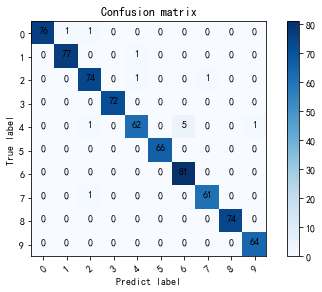

In [13]:
#plt.figure(figsize=(12,9))
y_pre = model.predict(X_test)
label_pre = np.argmax(y_pre, axis=1)
label_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(label_true, label_pre)
plot_confusion_matrix(confusion_mat, classes=range(10))